# Model Training

The EDA on our raw dataset showed we need to take some few simple steps to get it ready for modelling. We will start with those steps before getting on with building our multiclass classifier.

## 1.0 Import Libraries
The relevant libraries are imported. There are some nltk downloads that are only required when running this notebook for the first time. Subsequents runs do not require these downloads.

In [16]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
#uncomment the next two lines if running for the first time
# nltk.download('wordnet') 
# nltk.download('omw-1.4')
import itertools
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pipeline_config as pc
import model_training_utils as mtu


## 2.0 Preparing the data
The dataset is loaded from the file. The duplicates in the dataset are dropped, the names of the colums and the categories in the target column are modified for convenience. The name of one of the states and one of the categories that used an incorrect letter case were modified to reflect the correct case. Though it was not done during the EDA because it was not affecting the analysis, the descriptions of the complaints were sliced to remove the comments from FCC (a regulatory body).

In [2]:
#loading the dataset
print ('loading dataset...')
data = pd.read_csv('ComCast_FCC.csv')

loading dataset...


In [3]:
#dropping the duplicates in the dataset
primary_data = pd.DataFrame(data)
primary_data = primary_data.drop_duplicates(keep='first')
print(primary_data.shape)
primary_data.head()

(2208, 7)


,Customer Complaint,Category,Date,City,State,Zip code,Description
0,Comcast Cable Internet Speeds,Internet Problems,2015-04-22,Abingdon,Maryland,21009,I have been contacting Comcast Internet Techni...
1,Payment disappear - service got disconnected,Poor Customer Service,2015-04-08,Acworth,Georgia,30102,Back in January 2015 I made 2 payments: One fo...
2,Speed and Service,Internet Problems,2015-04-18,Acworth,Georgia,30101,Our home is located at in Acworth Georgia 3010...
3,Comcast Imposed a New Usage Cap of 300GB that ...,Billings,2015-05-07,Acworth,Georgia,30101,Comcast in the Atlanta area has just put into ...
4,Comcast not working and no service to boot,Internet Problems,2015-05-26,Acworth,Georgia,30101,I have been a customer of Comcast of some sort...


In [4]:
#modifying the names of the columns
primary_data.rename(columns = {'Customer Complaint':'customer_complaint', 
                                'Category':'category', 
                                'Date':'date',
                                'City':'city', 
                                'State':'state', 
                                'Zip code':'zip_code', 
                                'Description':'description'}, inplace = True)

In [5]:
#modifying the categories and correcting the incorrect leter case
primary_data['category'] = primary_data['category'].replace(
                            ['Billings', 'Internet Problems', 'Poor Customer Service', 'Data Caps', 'Other', 'other'], 
                            [0, 1, 2, 3, 4, 4])

In [6]:
#using the correct letter case
primary_data['state'] = primary_data['state'].replace('District of Columbia', 'District Of Columbia')

In [7]:
# split the descriptions on the dashes to extract the comments from FCC
primary_data[["description", "remainder"]] = primary_data["description"].str.split(
                                            "- - - - - - - - - - - - - - - - - - - - -",
                                            n=1,expand=True)

## 3.0 Modelling

### Train Test Split
The train test split was doing using the scikit learn standard test train split function. The train set size is 80%. Since the modelling will use gridsearchCV to find the best parameters, a validation set was not absolutely necessary so it was not factored in the split.


In [8]:
#input and target variables
X = primary_data.description
y = primary_data.category

In [9]:
#size of the variables
X.shape, y.shape

((2208,), (2208,))

In [10]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((1766,), (442,), (1766,), (442,))

### Model Training and Evaluation
The classifiers used in the modelling include:
A. Dummy Classifier: used to establish the base case
B. MultinimialNB, NB
C. Randomforest, RFC
D. SupportVectorMachine, SVM
E. ExtraTreeClassifier, XTC

The gridsearchCV was only done on the SVM and the XTC. The best parameters for each algorithm are used to train a model and the model with the best f1 score is chosen as the best performing model.

The metrics for evaluation are accuracy and macro f1 score.

In [34]:
model_metrics = mtu.model_metrics(pc.CLASSIFIERS, X_train, X_test, y_train, y_test)
model_metrics

,classifier,accuracy,micro_f1,weighted_f1,macro_f1
0,dummy,0.386878,0.386878,0.215844,0.111582
1,MNB,0.488688,0.488688,0.389033,0.290649
2,BGC,0.619910,0.619910,0.604388,0.573869
3,XTC,0.660633,0.660633,0.632979,0.602372
4,RFC,0.683258,0.683258,0.656779,0.629311
5,SVM,0.696833,0.696833,0.692081,0.656526
6,GBC,0.703620,0.703620,0.694426,0.667811
7,XGB,0.719457,0.719457,0.711486,0.683836
8,LGR,0.737557,0.737557,0.724880,0.684095


In [12]:
#grid search XGB pipeline
# parameters = pc.XGB_PARAMETERS

# cv = pc.CV

# gs_xgb_clf = GridSearchCV(pc.XGB_CLF, parameters, cv=cv, verbose=True)

# gs_xgb_clf.fit(X_train, y_train)

# # gs_svm_clf_pred = gs_svm_clf.predict(X_test)

# best_parameters = gs_xgb_clf.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [13]:
#define a XGB pipeline using result from grid search
from xgboost import XGBClassifier
xgb_clf_grid = Pipeline([
                ('vect', CountVectorizer(ngram_range = (1, 1))),
                ('tfidf', TfidfTransformer(use_idf = True)), 
                ('clf', XGBClassifier(n_estimators= 150,
                subsample= 0.9,
                gamma= 0.25,
                learning_rate= 0.20, 
                max_depth= 6,
                objective='logistic'))
])

#fit XGB pipeline
xgb_clf_grid.fit(X_train, y_train)

#evaluate XGB pipeline
xgb_pipeline_pred_grid  = xgb_clf_grid.predict(X_test)
acc_score_xgb_grid_pipeline = accuracy_score(y_test, xgb_pipeline_pred_grid )
F1_score_macro_xgb_grid_pipeline = f1_score(y_test, xgb_pipeline_pred_grid, average = 'macro')
print(acc_score_xgb_grid_pipeline, F1_score_macro_xgb_grid_pipeline)

0.7036199095022625 0.6698145154199431


In [14]:
#grid search LGR pipeline
# parameters = pc.LGR_PARAMETERS

# cv = pc.CV

# gs_lgr_clf = GridSearchCV(pc.LGR_CLF, parameters, cv=cv, verbose=True)

# gs_lgr_clf.fit(X_train, y_train)

# # gs_xtc_clf_pred = gs_xtc_clf.predict(X_test)

# best_parameters = gs_lgr_clf.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [17]:
#define a LGR pipeline using result from grid search
lgr_clf_grid = Pipeline([
        ('vect', CountVectorizer(ngram_range = (1, 1))),
        ('tfidf', TfidfTransformer(use_idf = True)),
         ('clf', LogisticRegression(multi_class = 'multinomial',
                                max_iter = 200,
                                penalty = 'l2',)),
])

#fit LGR pipeline
lgr_clf_grid.fit(X_train, y_train)

#evaluate LGR pipeline
lgr_pipeline_pred_grid  = lgr_clf_grid.predict(X_test)
acc_score_lgr_grid_pipeline = accuracy_score(y_test, lgr_pipeline_pred_grid )
F1_score_macro_lgr_grid_pipeline = f1_score(y_test, lgr_pipeline_pred_grid, average = 'macro')
print(acc_score_lgr_grid_pipeline, F1_score_macro_lgr_grid_pipeline)

0.7375565610859729 0.6840948368206813


# NLTK

In [19]:
#define a XGB pipeline using result from grid search
xgb_clf_nltk = Pipeline([
            ('text', pc.PROCESS_TEXT),
          ('vect', CountVectorizer(ngram_range = (1, 1))),
        ('tfidf', TfidfTransformer(use_idf = True)),
         ('clf', XGBClassifier()),
])

xgb_clf_nltk.fit(X_train, y_train)

xgb_nltk_pipeline_pred = xgb_clf_nltk.predict(X_test)
acc_score_xgb_nltk_pipeline = accuracy_score(y_test, xgb_nltk_pipeline_pred)
F1_score_micro_xgb_nltk_pipeline = f1_score(y_test, xgb_nltk_pipeline_pred, average = 'micro')
F1_score_weighted_xgb_nltk_pipeline = f1_score(y_test, xgb_nltk_pipeline_pred, average = 'weighted')
F1_score_macro_xgb_nltk_pipeline = f1_score(y_test, xgb_nltk_pipeline_pred, average = 'macro')
metrics_xgb_nltk = ['XGB_nltk', acc_score_xgb_nltk_pipeline, F1_score_micro_xgb_nltk_pipeline, 
                    F1_score_weighted_xgb_nltk_pipeline, F1_score_macro_xgb_nltk_pipeline]
print(metrics_xgb_nltk)

['XGB_nltk', 0.7217194570135747, 0.7217194570135745, 0.7158928860046111, 0.6926178545099183]


In [21]:
#LGR pipeline using result from grid search
lgr_clf_nltk = Pipeline([
        ('text', pc.PROCESS_TEXT),
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
         ('clf', LogisticRegression()),
])

lgr_clf_nltk.fit(X_train, y_train)

lgr_clf_nltk_pred = lgr_clf_nltk.predict(X_test)
acc_score_lgr_nltk_pipeline = accuracy_score(y_test, lgr_clf_nltk_pred)
F1_score_micro_lgr_nltk_pipeline = f1_score(y_test, lgr_clf_nltk_pred, average = 'micro')
F1_score_weighted_lgr_nltk_pipeline = f1_score(y_test, lgr_clf_nltk_pred, average = 'weighted')
F1_score_macro_lgr_nltk_pipeline = f1_score(y_test, lgr_clf_nltk_pred, average = 'macro')
metrics_lgr_nltk = ['LGR_nltk', acc_score_lgr_nltk_pipeline, F1_score_micro_lgr_nltk_pipeline, 
                    F1_score_weighted_lgr_nltk_pipeline, F1_score_macro_lgr_nltk_pipeline]
print(metrics_lgr_nltk)

['LGR_nltk', 0.7420814479638009, 0.7420814479638009, 0.7323978758774842, 0.7002275106881226]


In [35]:
model_metrics.loc[len(model_metrics.index)] = metrics_xgb_nltk
model_metrics.loc[len(model_metrics.index)] = metrics_lgr_nltk
model_metrics

,classifier,accuracy,micro_f1,weighted_f1,macro_f1
0,dummy,0.386878,0.386878,0.215844,0.111582
1,MNB,0.488688,0.488688,0.389033,0.290649
2,BGC,0.619910,0.619910,0.604388,0.573869
3,XTC,0.660633,0.660633,0.632979,0.602372
4,RFC,0.683258,0.683258,0.656779,0.629311
5,SVM,0.696833,0.696833,0.692081,0.656526
6,GBC,0.703620,0.703620,0.694426,0.667811
7,XGB,0.719457,0.719457,0.711486,0.683836
8,LGR,0.737557,0.737557,0.724880,0.684095
9,XGB_nltk,0.721719,0.721719,0.715893,0.692618


## Journey Map

<function matplotlib.pyplot.show(close=None, block=None)>

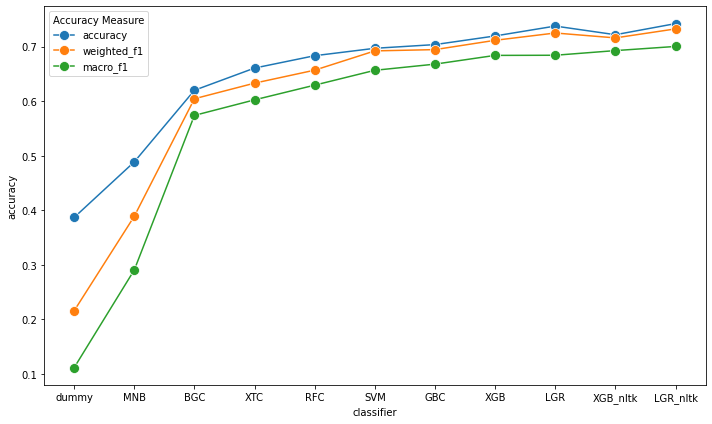

In [39]:
plt.figure(figsize=(10,6))
metrics = ['accuracy', 'weighted_f1', 'macro_f1']
for metric in metrics:
    sns.lineplot(data=model_metrics,
        x='classifier',  y=metric,
        marker='o', markersize=10,
    )
#plt.gcf().axes[0].yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
plt.legend(title='Accuracy Measure', labels = metrics, loc='upper left')
plt.tight_layout()
plt.show